# Auto encodeurs


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import Model, Input ## functional API
import keras
from keras.layers import (### dense neural network
                                    Dense, Flatten,

                                    ### convolutionnal neural network
                                    Reshape, Convolution2D, MaxPooling2D, AveragePooling2D,Resizing,

                                    ### data augmentation
                                    Rescaling, Dropout,RandomRotation, RandomFlip,
                                    
                                    ### parallel sub-models, use functionnal API
                                    Concatenate,

                                    ### inverse convolution for auto encoder
                                    Convolution2DTranspose, UpSampling2D,
                                    )
                

from keras.datasets import mnist,fashion_mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
def plot_lc(history: dict, metrics: list = ['loss', 'accuracy']) -> None:
    plt.figure(figsize=(20, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.title(f'Learning curve for {metric}\n')
        plt.plot(history[metric], label='train')
        plt.plot(history[f'val_{metric}'], label='val')
        plt.xlabel('epochs')
        plt.ylabel(metric)
        plt.legend()
        if metric == 'accuracy':
            plt.ylim(0,1.1)
    plt.show()




def plot_cm_display(y_true: np.array, y_pred: np.array) -> None:
    cm = confusion_matrix(y_true, y_pred)
    
    #plt.figure(figsize=(20, 8))
    #plt.title('Confusion Matrix\n')
    CM = ConfusionMatrixDisplay(cm)
    CM.plot()
    #sns.heatmap(cm, cmap='vlag', annot=True, fmt='d', cbar=False)
    #plt.xlabel('y_pred')
    #plt.ylabel('y_true')
    plt.show()

from itertools import chain, cycle
def plot_ae_results(n_samples: int, x_test: np.ndarray, y_test: np.ndarray, y_pred: np.ndarray):
    samples = chain.from_iterable([(x_test[idx], y_test[idx], y_pred[idx]) for idx in np.random.randint(0, x_test.shape[0], n_samples)])
    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(samples, cycle(('Noised', 'Original', 'Denoised',)))):
        plt.subplot(n_samples, 3, i+1)
        plt.title(title, fontdict={'fontsize': 12})
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Principe général

Les auto encodeurs(ae) sont des architectures particulières en deeplearning qui peuvent notamment servir à débruiter des données. Ces données peuvent être un signal(e.g. voix, musique), des images, des vidéos, *etc.*. Ils peuvent également être utilisés afin de colorer des images qui seraient en noir et blanc par exemple.


L'architecture variera en fonction des données mais le principe général reste le même. Il s'agit de projeter les données en entrée dans un espace latent qui sera ensuite utilisé pour reconstituer l'information. Vous pouvez interpréter cet esapace latent commme un résumé des informations essentielles.

L'apprentissage consiste à donner en entrée des données bruitées et de les comparer en sortie avec les données attendues, non bruitées.

Pour notre exemple ici, nous sommes repartis du dataset mnist et nous avons bruité artificiellement les images avec la fonction random noise de [scikit-image](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise).

In [3]:
def add_noise(X,noise_factor=0.05):

    SHAPE = X.shape

    ### garder les valeurs entre min et max originale
    X_noise = np.clip(a_max=np.max(X,axis=None),
                      a_min=np.min(X,axis=None),
                      a=X + noise_factor * np.random.normal(0,np.max(X,axis=None),SHAPE), ## loi normale centrée reduite
                     ) 
    
    return X_noise

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/np.max(X_train,axis=None)
X_test = X_test/np.max(X_test,axis=None)

In [5]:
noise_factor=0.2
X_train_noise,X_test_noise = add_noise(X_train,noise_factor),add_noise(X_test,noise_factor)

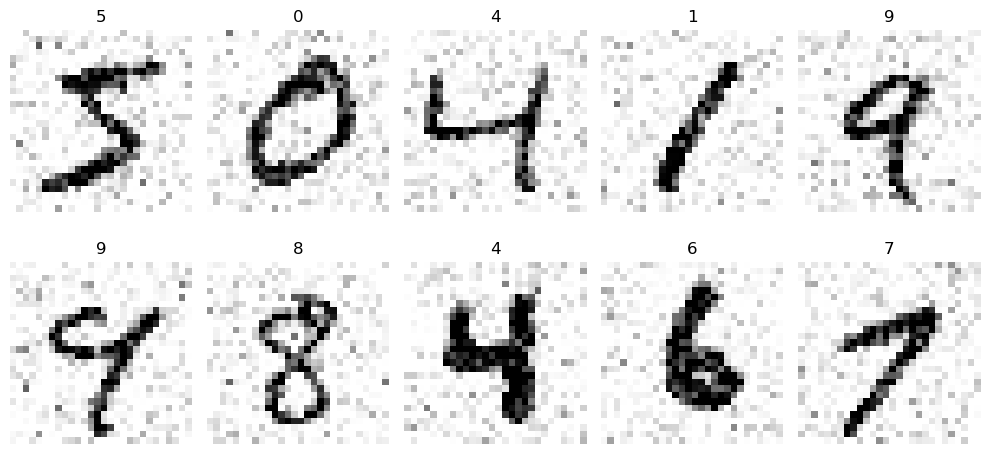

In [6]:
rdm_selection = np.random.randint(0,100,10)

plt.figure(figsize= (10,5) )
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_noise[i],cmap='Greys')
    plt.axis('off')
    plt.title(y_train[i])

    plt.subplot(2,5,6+i)
    plt.imshow(X_train_noise[rdm_selection[5+i]],cmap='Greys')
    plt.axis('off')
    plt.title(y_train[rdm_selection[5+i]])

plt.tight_layout()
plt.show()

# Conception de l'architecture et choix de la fonction coût

## Encodeur
Un auto encodeur est construit en deux parties. Une première, que l'on appelle l'encodeur dont le rôle consiste à projeter les features dans un espace réduit. Cet espace réduit est parfois appelé espace latent. Cet espace latent peut être un simple vecteur d'une taille réduite.

On peut d'ailleurs faire un rapprochement avec la PCA puisque dans les deux cas, l'objectif est de réduire la quantité de dimensions ceci dit avec une différence majeure puisque que contrairement à la PCA, un encodeur peut suivre une approche non linéaire.

## Décodeur
La seconde partie, appelée le décodeur utilise l'espace latent afin de reconstruire le signal. Cet espace latent, si le modèle est correctement entraîné, devrait contenir l'essentiel de l'information (*i.e.* pas de bruit).

## Fonction coût
Le choix de la fonction coût dépend bien évidemment de l'objectif poursuivi. Dans notre cas, nous cherchons à débruiter des images et donc l'image de sortie doit ressembler à l'image attendue. Pour calculer cette ressemblance, on peut simplement calculer une erreur quadratique moyenne en comparant les valeurs des pixels prédits avec ceux attendus. 
(=regression: plus ou moins les mêmes valeurs, sans le bruit)

In [7]:
def prepocessing(input_shape: tuple[int, ...], 
                 target_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)
    x = Reshape(target_shape)(inputs)
    return  Model(inputs=inputs, outputs=x, name='preprocessing')

def encoder(input_shape: tuple[int, ...], 
            z_size: int ## latent-space
           ) -> Model:
    
    inputs = Input(input_shape)

    x = Convolution2D(32, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(2, padding='same')(x)
    

    x = Convolution2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2, padding='same')(x)

    x = Convolution2D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2, padding='same')(x)
    ### 4,4,128
    x = Flatten()(x)
    

    ### z_size == espace latent/reduit
    x = Dense(z_size, activation='relu')(x)

    return Model(inputs=inputs, outputs=x, name='encoder')
    
def decoder(input_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)

    ### ajouter autres couches pour le décodeur: 
    ### -- avoir le nombre de pixels suffisant pour reconstruire l'image 
    x = Dense(2048, activation='relu')(inputs)
    
    ### reshape pour pouvoir appliquer les convolutions 2DTranspose
    ### attention la shape pour la convolution/convolutionTranspose
    x = Reshape((4, 4, 128))(x) ## 4*4*128 = 2048

    
    
    ### (4,4,...)
    x = Convolution2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    ### ?(8,8)
    x = Convolution2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    ### ?(16,16)
    x = Convolution2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    ### ?(32,32)
    x = Convolution2DTranspose(1, 3, padding='same', activation='relu')(x)

    return Model(inputs=inputs, outputs=x, name='decoder')

def autoencoder(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    
    x = encoder(x.shape[1:], z_size)(x)
    x = decoder(x.shape[1:])(x)

    x = Resizing(28, 28)(x)

    return Model(inputs=inputs, outputs=x, name='autoencoder')

In [8]:
ae = autoencoder(X_train.shape[1:], (28, 28, 1), 50)
ae.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)

# plot_model(ae, expand_nested=True, show_shapes=True, show_layer_activations=True)


In [10]:

H = ae.fit(X_train_noise ## noised images
       , X_train ## un noised/true images
       , batch_size=1024, epochs=3, validation_split=.2)



Epoch 1/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.0663 - val_loss: 0.0634
Epoch 2/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.0551 - val_loss: 0.0445
Epoch 3/3
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 0.0367 - val_loss: 0.0300


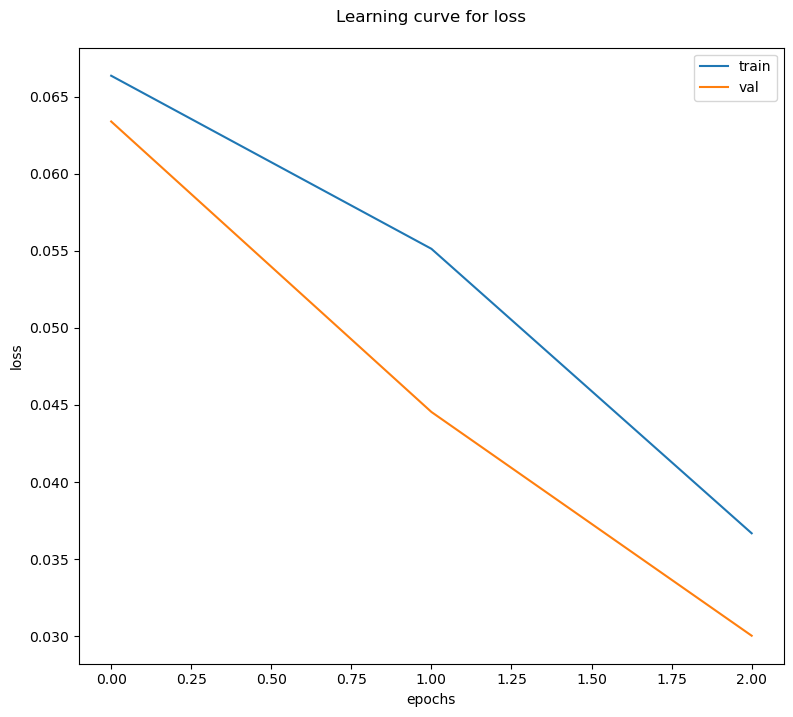

In [11]:
plot_lc(H.history, metrics=['loss'])



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


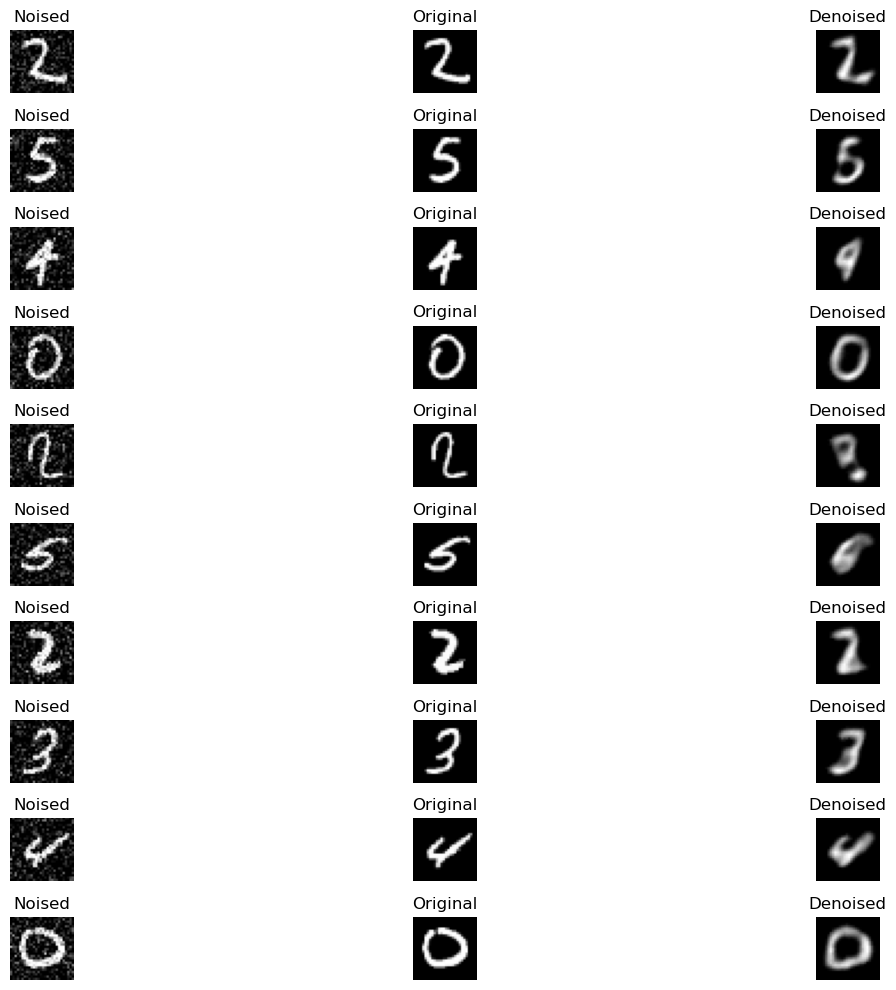

In [12]:
y_pred = ae.predict(X_test_noise) ## noised images
plot_ae_results(10, X_test_noise, X_test, y_pred)

## Alternatives possibles

- Nous aurions également pu utiliser de simples couches denses à la place des convolutions
- A la place des *convolutions2DTranspose*, nous pouvons utiliser des couches d'*upsampling* combinées à des couches de convolutions. A la différence des couches de convolutions tranposées, les couches d'upsampling en sont pas sujettes à un apprentissage.
- Des architectures plus complexes existent (*cfr.* unet)

In [13]:
def decoder_upsampling(input_shape: tuple[int, ...]) -> Model:
    inputs = Input(input_shape)

    x = Dense(2048, activation='relu')(inputs)
    
    x = Reshape((4, 4, 128))(x) ## 4*4*128 = 2048
    
    x = Convolution2D(128, 3, padding='same', activation='relu')(x)
    x = UpSampling2D(2)(x)

    x = Convolution2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D(2)(x)

    x = Convolution2D(32, 3, padding='same', activation='relu')(x)
    x = UpSampling2D(2)(x)

    x = Convolution2D(1, 3, padding='same', activation='relu')(x)
    
    return Model(inputs=inputs, outputs=x, name='decoder_upsampling')

def autoencoder(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    x = encoder(x.shape[1:], z_size)(x)
    x = decoder_upsampling(x.shape[1:])(x)

    x = Resizing(28, 28)(x)

    return Model(inputs=inputs, outputs=x, name='autoencoder')


Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 0.0728 - val_loss: 0.0647
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0578 - val_loss: 0.0477


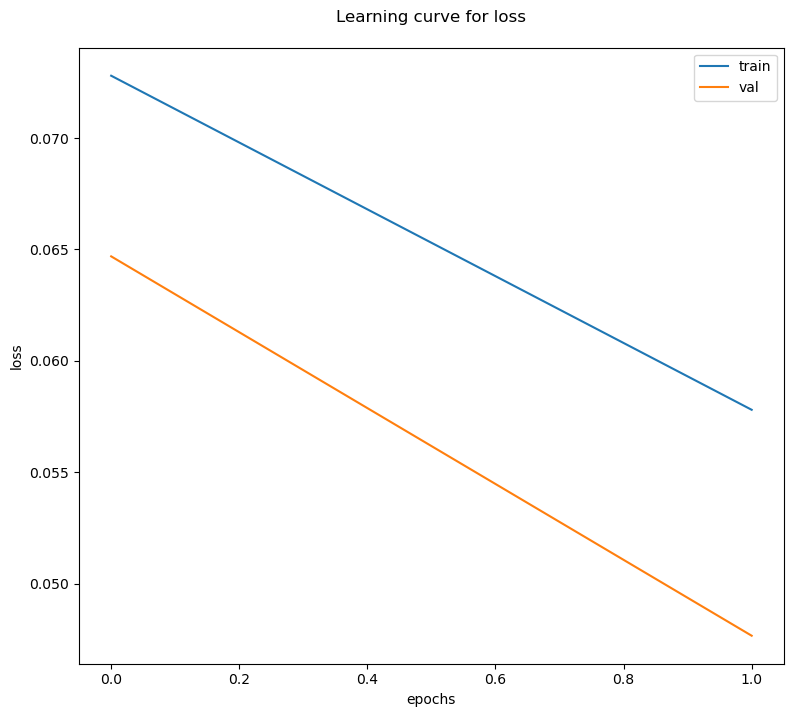

In [14]:
ae = autoencoder(X_train.shape[1:], (28, 28, 1), 50)
ae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError()
)

# plot_model(ae, show_shapes=True, expand_nested=True)

ae.fit(X_train_noise, X_train, batch_size=1024, epochs=2, validation_split=.2)
plot_lc(ae.history.history, metrics=['loss'])



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


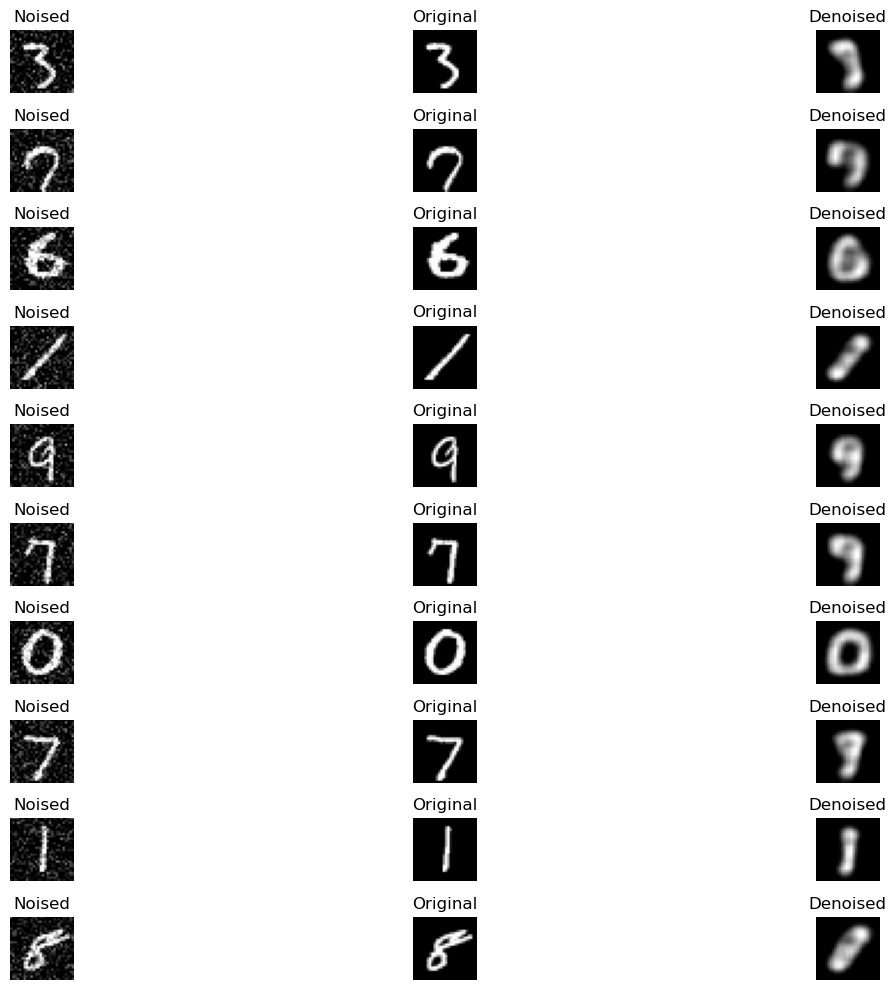

In [15]:
y_pred = ae.predict(X_test_noise)
plot_ae_results(10, X_test_noise, X_test, y_pred)

## Utiliser notre modèle pour débruiter ET classer des images


In [26]:
def classifier(input_shape: tuple[int, ...], n_labels: int) -> Model:
    inputs = Input(input_shape)

    x = Dense(512, activation='relu')(inputs)
    x = Dense(n_labels, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=x, name='classifier')

def autoencoder_classifier(input_shape: tuple[int, ...], target_shape: tuple[int, ...], z_size: int, n_labels: int) -> Model:
    inputs = Input(input_shape)

    x = prepocessing(input_shape, target_shape)(inputs)
    x_encoded = encoder(x.shape[1:], z_size)(x)

    ### use the result of encoding to decode: reconstruct image
    denoised = decoder(x_encoded.shape[1:])(x_encoded)
    denoised = Resizing(28, 28, name='denoised_out')(denoised)

    print(x_encoded.shape)
    ### reuse the result of encoding for a classification
    classifications = classifier(x_encoded.shape[1:], n_labels)(x_encoded) 

    return Model(inputs=inputs, outputs={'denoised':denoised, 'classifications':classifications}, name='autoencoder')


In [27]:
X_train_noise.shape

(60000, 28, 28)

In [ ]:
denoiser_classifier = autoencoder_classifier((28, 28), (28, 28, 1), 20, 10)

denoiser_classifier.compile(
    optimizer=keras.optimizers.Adam(),
    loss = {
        'denoised': keras.losses.MeanSquaredError(), ## metric for the decoder-part of the autoencoder
        'classifications':keras.losses.SparseCategoricalCrossentropy() ## metric for the classification       
    }
    ,
    #metrics = {
    #  
    #    ,'classifications': tf.keras.metrics.Accuracy()
    #}
)

denoiser_classifier.fit(x=X_train_noise ## noised images
                        ,y={
                            'denoised': X_train, ## un-noised images
                            'classifications': y_train ## label
                        },
                        epochs=2, batch_size=1024, validation_split=0.2)

(None, 20)
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - classifications_loss: 1.3550 - denoised_loss: 0.0707 - loss: 1.4277 - val_classifications_loss: 0.5951 - val_denoised_loss: 0.0520 - val_loss: 0.6477
Epoch 2/2
 4/47 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - classifications_loss: 0.6049 - denoised_loss: 0.0522 - loss: 0.6571

In [ ]:
denoiser_classifier.summary()

In [ ]:
tf.keras.utils.plot_model(
    model = denoiser_classifier,
    show_layer_activations=True,
    show_shapes=True,
    expand_nested=True
)

In [ ]:
H = denoiser_classifier.history.history
display(H)

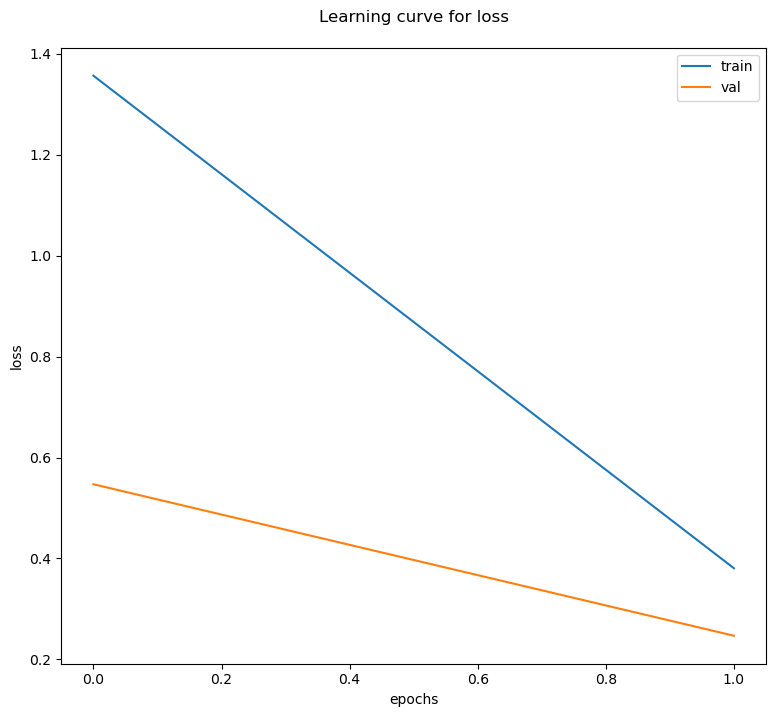

In [22]:
plot_lc(H,metrics=['loss'])

In [23]:
pred = denoiser_classifier.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [24]:
pred['classifications']

array([[5.5882801e-09, 2.1255724e-08, 1.2775686e-07, ..., 9.9997866e-01,
        5.6136333e-08, 1.6552940e-05],
       [2.0385460e-08, 3.7162106e-06, 9.9990904e-01, ..., 3.1347227e-11,
        9.8789169e-06, 1.1211504e-12],
       [2.8919076e-06, 9.8016751e-01, 1.8680822e-04, ..., 3.2666279e-03,
        7.0279092e-04, 3.1222819e-04],
       ...,
       [7.1263080e-09, 7.9008123e-07, 4.1767443e-08, ..., 2.4212355e-05,
        1.4353652e-05, 9.5554459e-04],
       [5.1126734e-04, 4.1027690e-08, 1.5435453e-06, ..., 2.7542490e-07,
        1.4536524e-03, 2.9591436e-06],
       [1.9640538e-05, 1.1318915e-10, 3.8660683e-06, ..., 7.0809737e-13,
        3.8238085e-08, 9.0587683e-11]], shape=(10000, 10), dtype=float32)

In [25]:
pred.keys()

dict_keys(['denoised', 'classifications'])